In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

In [25]:
def add_noise(img):
    noise = torch.randn(img.size())*0.2
    noisy_img = img +noise
    return noisy_img

In [26]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

In [27]:
trainset = MNIST('./data',train=True,transform=img_transform,download=True)
testset = MNIST('./data',train=False,transform=img_transform,download=True)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [28]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
            
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128,256),
            nn.ReLU(True),
            nn.Linear(256,28*28),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [6]:
def training(model,optimizer,criterion,epochs):
    hist={"loss":[],"MSE":[]}
    for epoch in tqdm(range(1,epochs+1),desc="Training",total=epochs):
        losses=[]
        mselosses=[]
        for batch in trainloader:
            img, _ = batch
            img = img.view(img.size(0), -1)
            noisy_img = add_noise(img)
            noisy_img = Variable(noisy_img)
            img = Variable(img)
        # ===================forward=====================
            output = model(noisy_img)
            loss = criterion(output, img)
            losses.append(loss.item())
            MSE_loss = nn.MSELoss()(output, img)
            mselosses.append(MSE_loss.item())
        # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        hist["loss"].append(np.array(losses).mean())
        hist["MSE"].append(np.array(mselosses).mean())
    return hist

In [7]:
model = autoencoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=1e-5)
epochs=50
hist=training(model,optimizer,criterion,epochs)

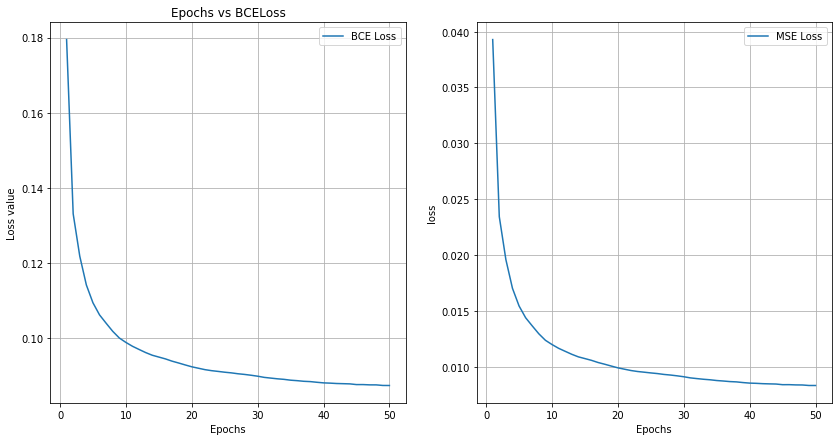

In [8]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ax[0].plot(range(1,epochs+1),hist["loss"],label="BCE Loss")
ax[0].grid()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss value")
ax[0].set_title("Epochs vs BCELoss")
ax[0].legend()
ax[1].plot(range(1,epochs+1),hist["MSE"],label="MSE Loss")
ax[1].grid()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].legend()

In [29]:
torch.save(model.state_dict(),"MNISTdenoisingweights.pth")

In [30]:
model=autoencoder()
model.load_state_dict(torch.load("MNISTdenoisingweights.pth"))

<All keys matched successfully>

In [31]:
def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [32]:
for i,data in enumerate(testloader):
    if(i==1):
        break;
    img,_=data
    img=img.view(img.size(0),-1)
    noisy_img=add_noise(img)
    img=Variable(img)
    noisy_img=Variable(noisy_img)
    output=model(noisy_img)
    original= to_img(img.cpu().data)
    clear= to_img(output.cpu().data)
    noised= to_img(noisy_img.cpu().data)
    save_image(original, './23_img/original.png')
    save_image(noised, './23_img/noised.png')
    save_image(clear, './23_img/clear.png')